In [1]:
import os
import pandas as pd
import numpy as np
import csv
from tqdm import tqdm_notebook as tqdm
from visualize import *
from utils import *
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error
from scipy.stats import uniform, randint
from tensorflow import set_random_seed

train_data_file = './data/train.csv'
test_file_dir = './data/test/'
submission_file = './submission.csv'

#SUBSET_SIZE = 120000000
SUBSET_SIZE = 60000000

n_mfcc=10 # Anzahl der MFCC Features

seed = 1234
np.random.seed(seed)
set_random_seed(seed)

Laden der Daten aus der CSV.

In [2]:
seismic_data  = pd.read_csv(train_data_file, dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32})
#seismic_data  = pd.read_csv(train_data_file, dtype={'acoustic_data': np.float32, 'time_to_failure': np.float32}, nrows=SUBSET_SIZE)

acoustic_data = seismic_data.acoustic_data.values.astype('float32')
time_to_failure = seismic_data.time_to_failure.values.astype('float32')

## Data Exploration

In [3]:
print("Total rows in dataset: %d" % len(seismic_data)) 

print("Top 5 rows:")
seismic_data.head(5)

Total rows in dataset: 629145480
Top 5 rows:


,acoustic_data,time_to_failure
0,12.0,1.4691
1,6.0,1.4691
2,8.0,1.4691
3,5.0,1.4691
4,8.0,1.4691


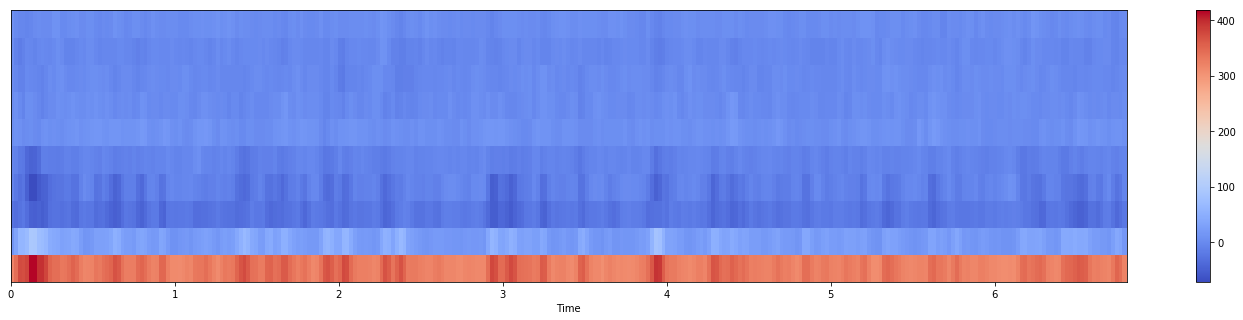

In [4]:
plot_mfcc(librosa.feature.mfcc(acoustic_data[:150000], n_mfcc=n_mfcc))

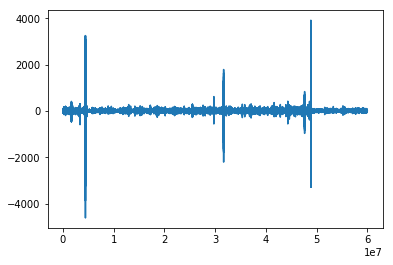

In [5]:
import matplotlib.pyplot as plt
import librosa, librosa.display

plt.plot(acoustic_data[:SUBSET_SIZE])

Splitten der gesamten Daten in Chunks von 150000 Datensätzen größe. Erstellen eines Dataframes mit den einzelnen MFCC features + time_to_failure.

In [6]:
import librosa, librosa.display

data_chunks = list(chunks(seismic_data, n=150000))
    
mfcc_ttf_map = {}    
for chunk in data_chunks:
    mfcc_chunk = librosa.feature.mfcc(chunk.acoustic_data.values.astype('float32'), n_mfcc=n_mfcc)
    mfcc_chunk_mean = mfcc_chunk.mean(axis=1)    
    
    for i, each_mfcc_mean in enumerate(mfcc_chunk_mean):    
        key = 'mfcc_{}'.format(i)
        if key not in mfcc_ttf_map:
            mfcc_ttf_map[key] = []
        mfcc_ttf_map[key].append(each_mfcc_mean)

    key = 'time_to_failure'
    if key not in mfcc_ttf_map:
        mfcc_ttf_map[key] = []        
    mfcc_ttf_map[key].append(chunk.time_to_failure.iloc[-1])
        
mfcc_ttf_df = pd.DataFrame(mfcc_ttf_map)

Plotten der einzelnen MFCC Features mit der time_to_failure Line um die realation der MFCC Features zum Zeitlichen Ereignisses zu sehen.

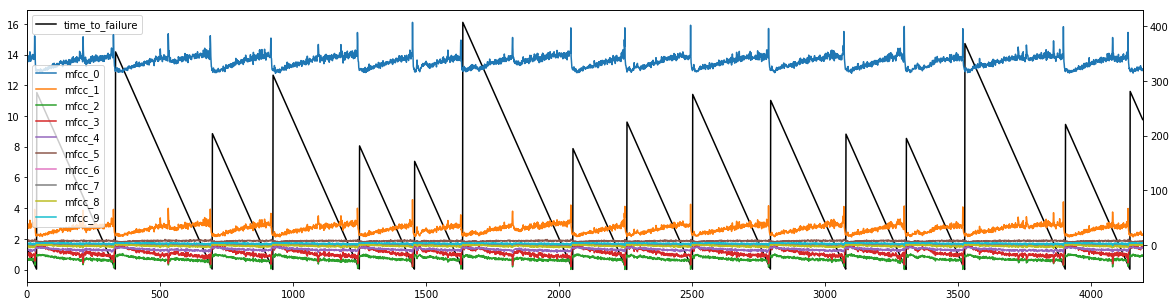

In [7]:
fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

mfcc_ttf_df['time_to_failure'].plot(ax=ax1, y='time_to_failure', legend=True, color='black')
ax1.legend(loc='upper left')
mfcc_ttf_df.drop(['time_to_failure'], axis=1).plot(ax=ax2, legend=True)
plt.show()

Wie man an diesem Diagramm sehen kann gibts es zwischen den Peaks mancher MFCC Features eine klare Relation zum auftreten des Erdbebens.

#### Do PCA

Reduzieren der MFCC Features per PCA auf aktuell nur noch ein einziges Feature.

In [8]:
from sklearn.decomposition import PCA

mfcc_data = mfcc_ttf_df.drop(['time_to_failure'], axis=1)

#pca = PCA(n_components=1).fit(mfcc_data)
pca = PCA(n_components=6).fit(mfcc_data)
reduced_data = pca.transform(mfcc_data)

reduced_data_frame = pd.DataFrame(reduced_data)
reduced_data_frame['time_to_failure'] = mfcc_ttf_df['time_to_failure']

#### After PCA

Plotten des durch das PCA erstellte Feature im Vergleich zum Timeline des Erdbebens. Das Signal wurde zusätzlich noch durch einen Savgol Filter geglättet, damit die Daten nicht so massiv osszilieren.

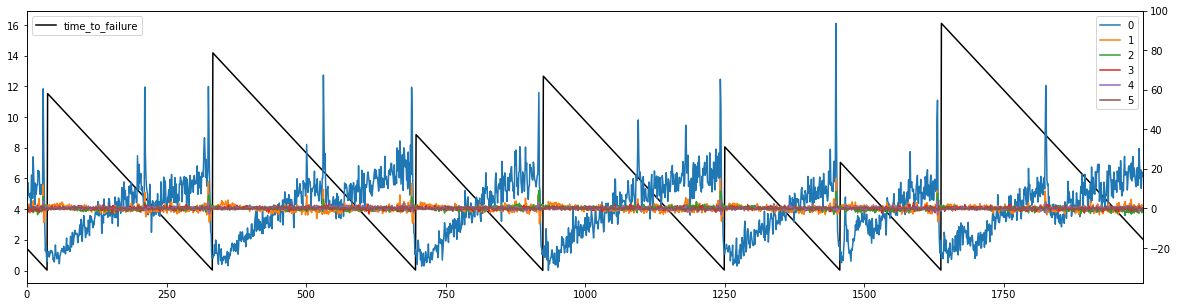

In [9]:
import scipy
from scipy.signal import savgol_filter


fig = plt.figure(figsize=[20,5])
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

from sklearn import preprocessing
from scipy import stats

data = reduced_data_frame.drop(['time_to_failure'], axis=1)
xx = data

#yhat = savgol_filter(np.ravel(xx.values), 175, 3)
#xx = pd.DataFrame(yhat)

reduced_data_frame['time_to_failure'][:2000].plot(ax=ax1, y='time_to_failure', legend=True, color='black')
ax1.legend(loc='upper left')
#reduced_data_frame.drop(['time_to_failure'], axis=1)[:1000].plot(ax=ax2, legend=True)
xx[:2000].plot(ax=ax2, legend=True)
plt.show()




Erstellen der Trainingsdaten mit dem neuen Feature.

In [10]:
preprocessed_data_frame = pd.DataFrame(xx)
preprocessed_data_frame['time_to_failure'] = mfcc_ttf_df['time_to_failure']

In [11]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import cross_val_score

#def report_cv(model):
#    X = preprocessed_data_frame.drop(['time_to_failure'], axis=1).values
#    y = preprocessed_data_frame['time_to_failure'].values
#    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=10)
#    print('Cross Validation scores: {}'.format(abs(scores)))
#    print('Average score: {}'.format(abs(scores.mean())))

#report_cv(RandomForestRegressor(max_depth=5, random_state=60, n_estimators=100,n_jobs = -1, min_samples_leaf= 30))

## Train / Test split

In [54]:
from sklearn.model_selection import train_test_split

#X = mfcc_ttf_df.drop(['time_to_failure'], axis=1).values
#y = mfcc_ttf_df['time_to_failure'].values

#X = reduced_data_frame.drop(['time_to_failure'], axis=1).values
#y = reduced_data_frame['time_to_failure'].values

X = preprocessed_data_frame.drop(['time_to_failure'], axis=1).values
y = preprocessed_data_frame['time_to_failure'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Benchmark

Methode um den Score zu printen.

In [13]:
def print_scores(model, X, y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=5)    
    print('Cross Validation scores: {}'.format(abs(scores)))
    print('Average score: {}'.format(abs(scores.mean())))

In [14]:
def print_mean_absolute_error(model):
    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print('Average score (MAE): {}'.format(mae))

Verwenden ein K-Nearest Neighbor um einen Referenze-/Benchmark Score zu erhalten.

In [15]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors = 14)
knn.fit(X_train, y_train)

print_scores(knn, X_test, y_test)
print_mean_absolute_error(knn)

Cross Validation scores: [2.26325158 2.12314617 2.10782759 2.08737932 2.02637987]
Average score: 2.121596905164351
Average score (MAE): 2.0753105272872445


## Data Preprocessing

Methode zum Vorverarbeiten der Daten die aus den Testfiles gelesen werden. Diese Methode soll sicher stellen das die Input Daten für das finale Model auch dem Datenformat entsprechen das auch trainiert wurde.

#### ACHTUNG: HIER FEHLT NOCH DIE SIGNALGLÄTTUNG

In [16]:
def extract_features(seismic_data):
    mfcc = librosa.feature.mfcc(seismic_data, n_mfcc=n_mfcc)    
    mfcc_mean = mfcc.mean(axis=1)
        
    feature_map = {}
    
    for i, each_mfcc_mean in enumerate(mfcc_mean):
        key = 'f{}'.format(i)
        if key not in feature_map:
            feature_map[key] = []
        feature_map[key].append(each_mfcc_mean)    
    
    reduced = pca.transform(pd.DataFrame(feature_map))    
    return reduced

## Implementation

In [17]:
#Xgboost example
#https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

#LightGBM examp1le
#https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py

Methode zum schreiben der Submission File für die Übertragung an Kaggle.

In [31]:
def write_submission(output_file, model, isRNN=False):
    test_files = resolve_csv_files(test_file_dir)    
    
    with open(output_file, 'w', newline='') as outcsv:
        writer = csv.DictWriter(outcsv, fieldnames = ['seg_id', 'time_to_failure'])
        writer.writeheader()
        
        for file in tqdm(test_files[:10]):
            seismic_test_data  = pd.read_csv(file, dtype={'acoustic_data': np.float32})
            features = extract_features(seismic_test_data.acoustic_data.values.astype('float32')) 
            if isRNN:
                features = np.reshape(features, (features.shape[0], 1, features.shape[1]))
            
            prediction = model.predict(features)[0]
            
            if isRNN:
                prediction = prediction[0]
            
            writer.writerow({'seg_id': stem_filename(file), 'time_to_failure': prediction})

In [19]:

write_submission(submission_file, knn)

Erstellen einer Pipeline mit mehreren Machine Learning Algorithmen und einer Reihe von dazugehörigen Parametern über die per RandomizedSearchCV das beste Model ermittelt werden soll.

In [20]:
from sklearn import pipeline, metrics
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# set up pipeline
est = pipeline.Pipeline([
        ('xgb', XGBRegressor(silent=True)),
   #     ('rfr', RandomForestRegressor(n_estimators=18, random_state=3, max_depth=3,
   #                                     min_weight_fraction_leaf=0.1,max_leaf_nodes = 20,
   #                                    min_samples_split = 20)),
])



# Paramter die versuchet werden sollen. Der Parameter hat immer einen Prefix ${Name des Algorithmus in der Pipeline z.B. 'xbg'}
# gefolgt von 2x underscore und dann nen eigentlichen Namen des Parameters.

params = {
    'xgb__learning_rate': [0.003, 0.005, 0.01, 0.05, 0.1],
    'xgb__min_child_weight': [5, 6, 7, 8, 9, 10, 11, 12],
    'xgb__subsample': [0.5, 0.7, 0.9],
    'xgb__colsample_bytree': [0.5, 0.7, 0.9],
    'xgb__max_depth': [1, 3, 5, 7, 9, 11],
    'xgb__n_estimators': [10, 50, 100, 150],
    
    #'rfr__bootstrap': [True, False],
    #'rfr__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    #'rfr__max_features': ['auto', 'sqrt'],
    #'rfr__min_samples_leaf': [1, 2, 4],
    #'rfr__min_samples_split': [2, 5, 10],
    #'rfr__n_estimators': [130, 180, 230]
}

#cv_sets = ShuffleSplit(n_splits=50, test_size=0.2, random_state=seed) # dauert sehr lange
cv_sets = ShuffleSplit(n_splits=10, test_size=0.2, random_state=seed)

search = RandomizedSearchCV(estimator=est, 
                            param_distributions=params, scoring='neg_mean_absolute_error', random_state=seed, 
                            #n_iter=100, cv=3, verbose=1, n_jobs=1, return_train_score=True)
                            n_iter=100, cv=cv_sets, verbose=1, n_jobs=1, return_train_score=True)
                            

search.fit(X_train, y_train)

print(search.best_estimator_)

# to prevent stange prediction bug - save and reload model: https://github.com/dmlc/xgboost/issues/1238
#TEMP_MODEL = 'tmp_xgbregressor.mdl'
#search.best_estimator_.save_model(TEMP_MODEL)
#search.best_estimator_.load_model(TEMP_MODEL)
#os.remove(TEMP_MODEL)

print_scores(search.best_estimator_, X_test, y_test)
print_mean_absolute_error(search.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  5.5min finished


Pipeline(memory=None,
     steps=[('xgb', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=8, missing=None, n_estimators=50, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7))])
Cross Validation scores: [2.38460548 1.95389529 1.9432157  2.11157633 1.88867565]
Average score: 2.0563936913190135
Average score (MAE): 2.0790667611355222


In [21]:
#Average score: 2.184982829934742
#Average score (MAE): 2.1759349740375638

In [22]:
write_submission(submission_file, search.best_estimator_)


One option for a smarter implementation of hyperparameter tuning is to combine random search and grid search:

Use random search with a large hyperparameter grid
Use the results of random search to build a focused hyperparameter grid around the best performing hyperparameter values.
Run grid search on the reduced hyperparameter grid.
Repeat grid search on more focused grids until maximum computational/time budget is exceeded.
Or could even look into using hyperopt. Here might be a good example of how to use this bayesian optimization technique in python.

https://github.com/hyperopt/hyperopt  
https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0

In [65]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, RepeatVector
from keras.optimizers import Adam, Adadelta, SGD, RMSprop
from keras import losses
from keras.callbacks import TensorBoard
import time

X_train_reshape = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))


model = Sequential()
model.add(LSTM(32, input_shape=(None,6)))
model.add(Dropout(0.20))
#model.add(RepeatVector(512))
model.add(Dense(1, activation="relu"))

#optimizer = Adam(lr=0.0001)
#optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
#optimizer = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = RMSprop(lr=0.0005, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss=losses.mean_absolute_error, optimizer=optimizer, metrics=['mae'])
             
now = time.strftime("%Y%m%d_%H%M%S")    
tensorboard_callback = TensorBoard(log_dir='./logs/'+now, histogram_freq=0, write_graph=True, write_images=True)    


model.fit(X_train_reshape, y_train,
              epochs=200,
              batch_size=128,
              validation_split=0.05,
              verbose=1,
              callbacks=[tensorboard_callback]
            )
              
#print(model.summary())
score = model.evaluate(X_test_reshape, y_test, batch_size=128)

Train on 3188 samples, validate on 168 samples
Epoch 1/200
3188/3188 [==============================] - ETA: 26s - loss: 6.1565 - mean_absolute_error: 6.15 - ETA: 2s - loss: 5.7763 - mean_absolute_error: 5.7763 - ETA: 0s - loss: 5.7331 - mean_absolute_error: 5.733 - ETA: 0s - loss: 5.6339 - mean_absolute_error: 5.633 - 1s 468us/step - loss: 5.5886 - mean_absolute_error: 5.5886 - val_loss: 3.6762 - val_mean_absolute_error: 3.6762
Epoch 2/200
3188/3188 [==============================] - ETA: 0s - loss: 5.6012 - mean_absolute_error: 5.601 - ETA: 0s - loss: 5.5525 - mean_absolute_error: 5.552 - ETA: 0s - loss: 5.4565 - mean_absolute_error: 5.456 - 0s 56us/step - loss: 5.4458 - mean_absolute_error: 5.4458 - val_loss: 3.5418 - val_mean_absolute_error: 3.5418
Epoch 3/200
3188/3188 [==============================] - ETA: 0s - loss: 5.7128 - mean_absolute_error: 5.712 - ETA: 0s - loss: 5.3982 - mean_absolute_error: 5.398 - ETA: 0s - loss: 5.3554 - mean_absolute_error: 5.355 - ETA: 0s - loss: 5.

Epoch 21/200
3188/3188 [==============================] - ETA: 0s - loss: 3.7207 - mean_absolute_error: 3.720 - ETA: 0s - loss: 3.7901 - mean_absolute_error: 3.790 - ETA: 0s - loss: 3.7511 - mean_absolute_error: 3.751 - ETA: 0s - loss: 3.7055 - mean_absolute_error: 3.705 - ETA: 0s - loss: 3.6878 - mean_absolute_error: 3.687 - 0s 88us/step - loss: 3.6632 - mean_absolute_error: 3.6632 - val_loss: 2.1212 - val_mean_absolute_error: 2.1212
Epoch 22/200
3188/3188 [==============================] - ETA: 0s - loss: 3.8363 - mean_absolute_error: 3.836 - ETA: 0s - loss: 3.5297 - mean_absolute_error: 3.529 - ETA: 0s - loss: 3.5413 - mean_absolute_error: 3.541 - ETA: 0s - loss: 3.5822 - mean_absolute_error: 3.582 - ETA: 0s - loss: 3.5530 - mean_absolute_error: 3.553 - ETA: 0s - loss: 3.5550 - mean_absolute_error: 3.555 - 0s 102us/step - loss: 3.5592 - mean_absolute_error: 3.5592 - val_loss: 2.0423 - val_mean_absolute_error: 2.0423
Epoch 23/200
3188/3188 [==============================] - ETA: 0s -

Epoch 39/200
3188/3188 [==============================] - ETA: 0s - loss: 2.3277 - mean_absolute_error: 2.327 - ETA: 0s - loss: 2.1923 - mean_absolute_error: 2.192 - ETA: 0s - loss: 2.2489 - mean_absolute_error: 2.248 - ETA: 0s - loss: 2.2307 - mean_absolute_error: 2.230 - 0s 70us/step - loss: 2.2905 - mean_absolute_error: 2.2905 - val_loss: 1.0311 - val_mean_absolute_error: 1.0311
Epoch 40/200
3188/3188 [==============================] - ETA: 0s - loss: 2.4212 - mean_absolute_error: 2.421 - ETA: 0s - loss: 2.3035 - mean_absolute_error: 2.303 - ETA: 0s - loss: 2.2251 - mean_absolute_error: 2.225 - ETA: 0s - loss: 2.2389 - mean_absolute_error: 2.238 - 0s 71us/step - loss: 2.2521 - mean_absolute_error: 2.2521 - val_loss: 1.0231 - val_mean_absolute_error: 1.0231
Epoch 41/200
3188/3188 [==============================] - ETA: 0s - loss: 1.9357 - mean_absolute_error: 1.935 - ETA: 0s - loss: 2.1596 - mean_absolute_error: 2.159 - ETA: 0s - loss: 2.1917 - mean_absolute_error: 2.191 - ETA: 0s - 

Epoch 77/200
3188/3188 [==============================] - ETA: 0s - loss: 2.1843 - mean_absolute_error: 2.184 - ETA: 0s - loss: 2.0867 - mean_absolute_error: 2.086 - ETA: 0s - loss: 2.1120 - mean_absolute_error: 2.112 - ETA: 0s - loss: 2.0794 - mean_absolute_error: 2.079 - ETA: 0s - loss: 2.0892 - mean_absolute_error: 2.089 - 0s 89us/step - loss: 2.0971 - mean_absolute_error: 2.0971 - val_loss: 1.2778 - val_mean_absolute_error: 1.2778
Epoch 78/200
3188/3188 [==============================] - ETA: 0s - loss: 2.3005 - mean_absolute_error: 2.300 - ETA: 0s - loss: 2.1597 - mean_absolute_error: 2.159 - ETA: 0s - loss: 2.1560 - mean_absolute_error: 2.156 - ETA: 0s - loss: 2.1023 - mean_absolute_error: 2.102 - ETA: 0s - loss: 2.1057 - mean_absolute_error: 2.105 - 0s 87us/step - loss: 2.0905 - mean_absolute_error: 2.0905 - val_loss: 1.2795 - val_mean_absolute_error: 1.2795
Epoch 79/200
3188/3188 [==============================] - ETA: 0s - loss: 2.0301 - mean_absolute_error: 2.030 - ETA: 0s - 

3188/3188 [==============================] - ETA: 0s - loss: 1.9907 - mean_absolute_error: 1.990 - ETA: 0s - loss: 2.0572 - mean_absolute_error: 2.057 - ETA: 0s - loss: 2.0350 - mean_absolute_error: 2.035 - ETA: 0s - loss: 2.0603 - mean_absolute_error: 2.060 - ETA: 0s - loss: 2.0686 - mean_absolute_error: 2.068 - 0s 77us/step - loss: 2.0675 - mean_absolute_error: 2.0675 - val_loss: 1.3459 - val_mean_absolute_error: 1.3459
Epoch 114/200
3188/3188 [==============================] - ETA: 0s - loss: 2.0095 - mean_absolute_error: 2.009 - ETA: 0s - loss: 2.0549 - mean_absolute_error: 2.054 - ETA: 0s - loss: 2.0514 - mean_absolute_error: 2.051 - ETA: 0s - loss: 2.0410 - mean_absolute_error: 2.041 - 0s 72us/step - loss: 2.0410 - mean_absolute_error: 2.0410 - val_loss: 1.3539 - val_mean_absolute_error: 1.3539
Epoch 115/200
3188/3188 [==============================] - ETA: 0s - loss: 2.2406 - mean_absolute_error: 2.240 - ETA: 0s - loss: 2.1519 - mean_absolute_error: 2.151 - ETA: 0s - loss: 2.059

Epoch 151/200
3188/3188 [==============================] - ETA: 0s - loss: 2.2099 - mean_absolute_error: 2.209 - ETA: 0s - loss: 2.0243 - mean_absolute_error: 2.024 - ETA: 0s - loss: 2.0539 - mean_absolute_error: 2.053 - ETA: 0s - loss: 2.0537 - mean_absolute_error: 2.053 - ETA: 0s - loss: 2.0352 - mean_absolute_error: 2.035 - 0s 81us/step - loss: 2.0272 - mean_absolute_error: 2.0272 - val_loss: 1.3893 - val_mean_absolute_error: 1.3893
Epoch 152/200
3188/3188 [==============================] - ETA: 0s - loss: 1.9725 - mean_absolute_error: 1.972 - ETA: 0s - loss: 2.0175 - mean_absolute_error: 2.017 - ETA: 0s - loss: 2.0716 - mean_absolute_error: 2.071 - ETA: 0s - loss: 2.0412 - mean_absolute_error: 2.041 - ETA: 0s - loss: 2.0425 - mean_absolute_error: 2.042 - ETA: 0s - loss: 2.0400 - mean_absolute_error: 2.040 - 0s 95us/step - loss: 2.0339 - mean_absolute_error: 2.0339 - val_loss: 1.3842 - val_mean_absolute_error: 1.3842
Epoch 153/200
3188/3188 [==============================] - ETA: 0s

Epoch 188/200
3188/3188 [==============================] - ETA: 0s - loss: 2.0117 - mean_absolute_error: 2.011 - ETA: 0s - loss: 1.9941 - mean_absolute_error: 1.994 - ETA: 0s - loss: 2.0525 - mean_absolute_error: 2.052 - ETA: 0s - loss: 2.0288 - mean_absolute_error: 2.028 - ETA: 0s - loss: 2.0334 - mean_absolute_error: 2.033 - 0s 84us/step - loss: 2.0139 - mean_absolute_error: 2.0139 - val_loss: 1.4080 - val_mean_absolute_error: 1.4080
Epoch 189/200
3188/3188 [==============================] - ETA: 0s - loss: 2.1558 - mean_absolute_error: 2.155 - ETA: 0s - loss: 1.9646 - mean_absolute_error: 1.964 - ETA: 0s - loss: 1.9952 - mean_absolute_error: 1.995 - ETA: 0s - loss: 2.0387 - mean_absolute_error: 2.038 - ETA: 0s - loss: 2.0169 - mean_absolute_error: 2.016 - 0s 79us/step - loss: 2.0087 - mean_absolute_error: 2.0087 - val_loss: 1.4170 - val_mean_absolute_error: 1.4170
Epoch 190/200
3188/3188 [==============================] - ETA: 0s - loss: 2.3082 - mean_absolute_error: 2.308 - ETA: 0s

In [66]:
write_submission('./submission_rnn.csv', model, isRNN=True)

In [25]:
## DAS IST DIE REFERENZ

# PCA mit 4 KOMPONENTEN
#
'''
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from keras.optimizers import Adam, Adadelta, SGD
from keras import losses
from keras.callbacks import TensorBoard
import time

X_train_reshape = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshape = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(32, input_shape=(None,6)))
model.add(Dropout(0.2))
#model.add(RepeatVector(512))
model.add(Dense(1, activation="relu"))

#optimizer = Adam(lr=0.0001)
#optimizer = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
optimizer = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=losses.mean_absolute_error, optimizer=optimizer, metrics=['mae'])


             
now = time.strftime("%Y%m%d_%H%M%S")    
tensorboard_callback = TensorBoard(log_dir='./logs/'+now, histogram_freq=0, write_graph=True, write_images=True)    


model.fit(X_train_reshape, y_train,
              epochs=200,
              batch_size=128,
              validation_split=0.05,
              verbose=1,
              callbacks=[tensorboard_callback]
            )
              
score = model.evaluate(X_test_reshape, y_test, batch_size=128)
'''
!!Epoch 150/150
!!val_mean_absolute_error: 1.8765

!! val_mean_absolute_error: 2.2048
!! KAGGLE Score: Platz: 873 Score: 1.470

    
    

['Der Befehl "KAGGLE" ist entweder falsch geschrieben oder',
 'konnte nicht gefunden werden.']

In [26]:
#https://machinelearningmastery.com/save-load-keras-deep-learning-models/
'''
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
    
    
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
'''

'\n# serialize model to JSON\nmodel_json = model.to_json()\nwith open("model.json", "w") as json_file:\n    json_file.write(model_json)\n# serialize weights to HDF5\nmodel.save_weights("model.h5")\nprint("Saved model to disk")\n\n# load json and create model\njson_file = open(\'model.json\', \'r\')\nloaded_model_json = json_file.read()\njson_file.close()\nloaded_model = model_from_json(loaded_model_json)\n# load weights into new model\nloaded_model.load_weights("model.h5")\nprint("Loaded model from disk")\n \n    \n    \n# evaluate loaded model on test data\nloaded_model.compile(loss=\'binary_crossentropy\', optimizer=\'rmsprop\', metrics=[\'accuracy\'])\nscore = loaded_model.evaluate(X, Y, verbose=0)\nprint("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))\n'